# Create RGB Color image from IRAC ====

In [18]:
# For Sky Plots se: http://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html
import numpy as np
from astropy.table import Table, join, vstack, hstack, Column, MaskedColumn

from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.visualization import MinMaxInterval, SqrtStretch,ImageNormalize, ManualInterval, PercentileInterval
import functions as fcs
from astropy.io import fits

In [2]:
# Read Images & Construct WCS ==============================
irac_1 = fcs.readfits('idl_results/OPH_ALL_COMB_IRAC1_mosaic_wcs_aligned_rotated_trimmed.fits')
irac_2 = fcs.readfits('idl_results/OPH_ALL_COMB_IRAC2_mosaic_wcs_aligned_rotated_trimmed.fits')
irac_4 = fcs.readfits('idl_results/OPH_ALL_COMB_IRAC4_mosaic_rotated_trimmed.fits')
imgs   = [irac_1['data'], irac_2['data'], irac_4['data']]

In [3]:
# Read Odisea Sample ==========
odisea_A = Table.read('odisea_samples/SAMPLE_A_C4.txt', format = 'ascii.fast_no_header') ; odisea_A.label = 'Sample A'
odisea_B = Table.read('odisea_samples/SAMPLE_B_C5.txt', format = 'ascii.fast_no_header') ; odisea_B.label = 'Sample B'

# Add coordinates =============
for inp in [odisea_A, odisea_B]:
    coords     = SkyCoord(inp['col1'], inp['col2'], unit=(u.hourangle, u.deg))
    inp['ra']  = [coord.ra.deg  for coord in coords]
    inp['dec'] = [coord.dec.deg for coord in coords]
    
    for col in ['ra', 'dec']:
        inp[col].unit   = u.degree
        inp[col].format = "10.5f"

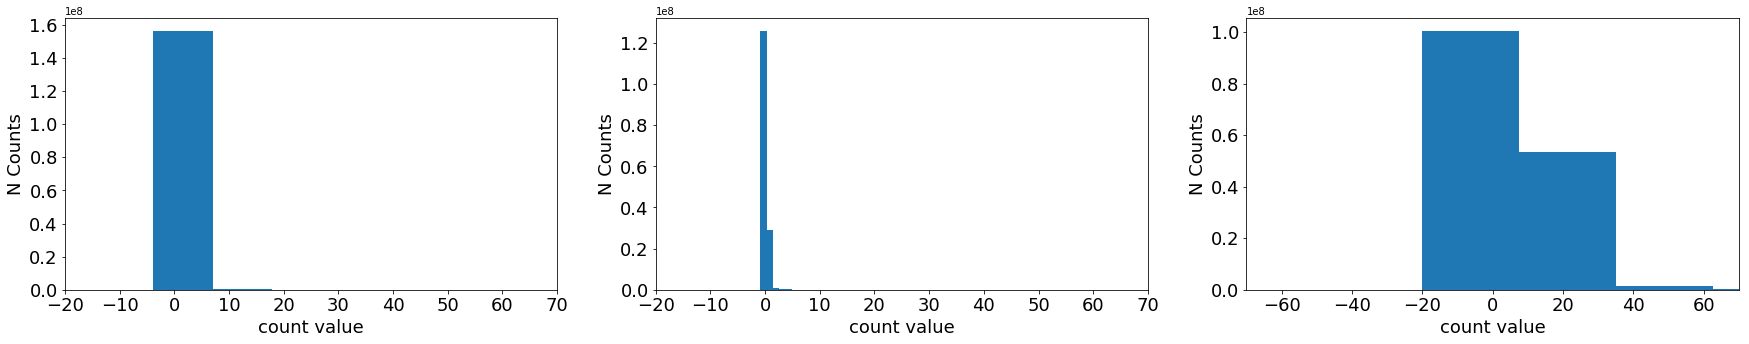

In [4]:
#Lets find best strecht to choose for the images =====
fig    = plt.figure(figsize=[30,5])
xlims  = [[-20,+70], [-20,+70], [-70,70]]
ftsize = 18
for i in range(len(imgs)):
    plt.subplot(131+i)
    plt.hist(imgs[i].flatten(), 800)
    plt.xlabel('count value', fontsize = ftsize)
    plt.ylabel('N Counts', fontsize = ftsize)
    plt.xticks(fontsize = ftsize)
    plt.yticks(fontsize = ftsize)
    plt.xlim(xlims[i])

plt.show()

In [5]:
#Re-scale Images =====================================
vmins     = [0, 0, 2]
vmaxs     = [7,7,50]
imgs_scl  = []
imgs_sqrt = []


for i in range(len(imgs)):
    interval = ManualInterval(vmin=vmins[i], vmax=vmaxs[i]) # Normalize [0:1] the image within the given threshold
    stretch  = SqrtStretch()+ PercentileInterval(98.)       # Apply sqrt Strecht

    imgs_scl.append(interval(imgs[i]))
    imgs_sqrt.append(stretch(interval(imgs[i])))


# Append RGB image ===================================
imgs_scl.append(( np.dstack((imgs_scl[2], imgs_scl[1], imgs_scl[0])) *255).astype(np.uint8)) # Linear Strecht
imgs_sqrt.append((np.dstack((imgs_sqrt[2],imgs_sqrt[1],imgs_sqrt[0]))*255).astype(np.uint8)) # Sqrt   Strecht

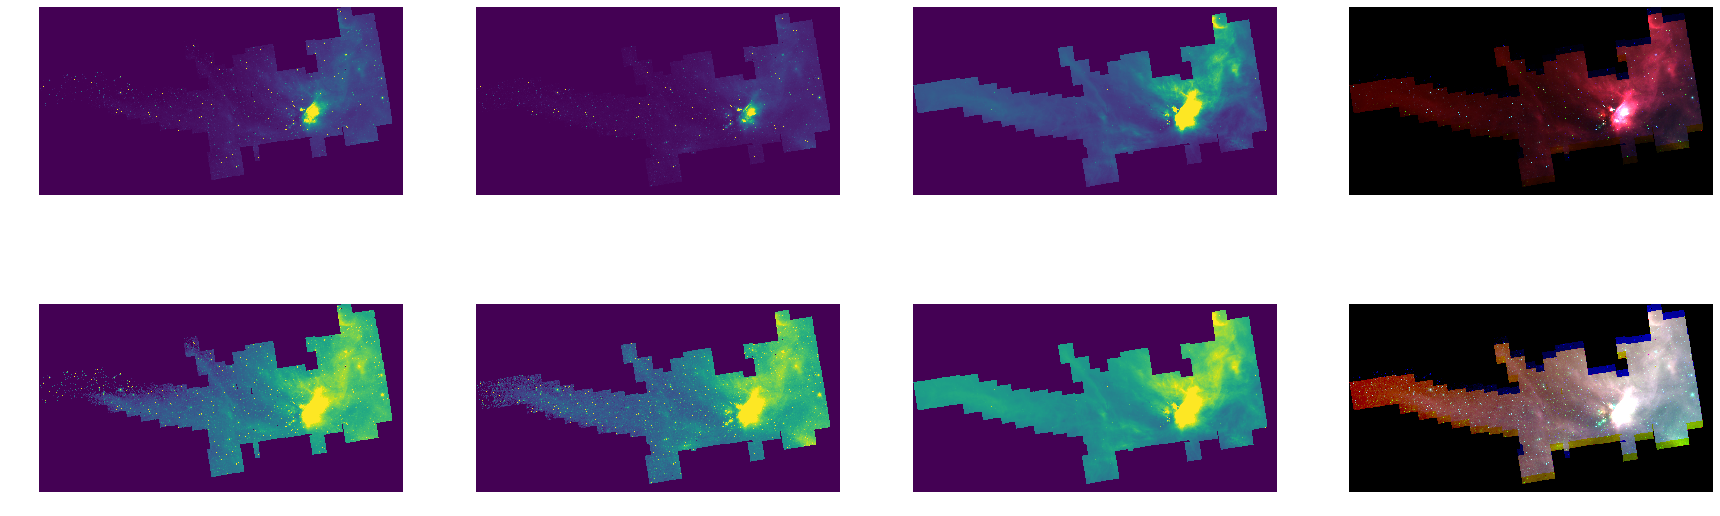

In [6]:
# Create & Plot final images =========================
fig   = plt.figure(figsize=[30,10])
imgs  = imgs_scl + imgs_sqrt
index = iter(range(len(imgs)))

for inp in imgs:
    plt.subplot(241 + next(index))
    plt.imshow(inp, origin='lower')
    plt.axis('off')
    
plt.show()

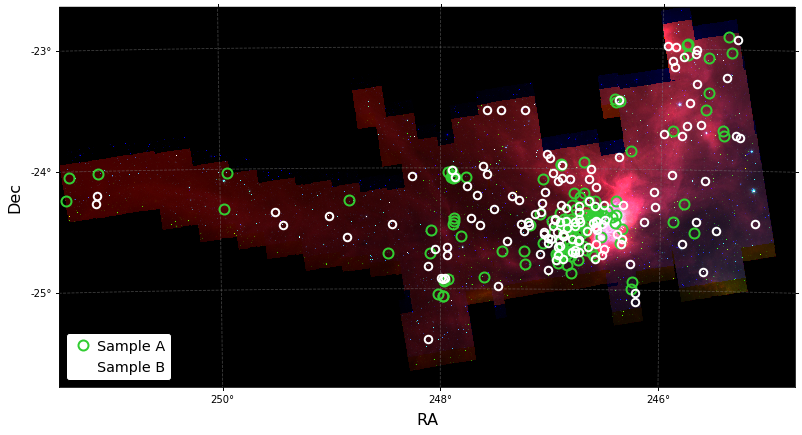

In [7]:
# Plot test image ====================================
inp_img = {'data':imgs_scl[3], 'hdr':irac_4['hdr'], 'wcs':irac_4['wcs']}
ftsize  = 16
mec_a   = 'limegreen'
mec_b   = 'w'
figname = 'odisea_rgb.pdf'

dummy   = fcs.make_img(inp_img, sample_A=odisea_A, sample_B=odisea_B, mec_a=mec_a, mec_b=mec_b,
                     figname=figname, ftsize=ftsize, mew=2)

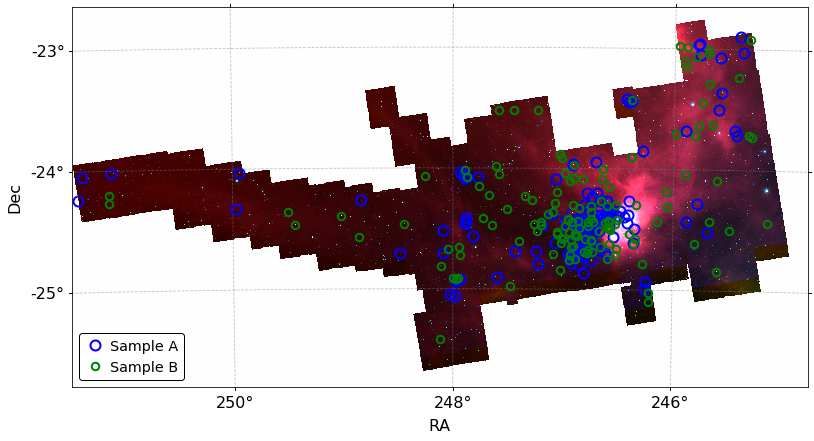

In [8]:
# Change background to white =========================
mask  = irac_4['data'] < 2
inp   = imgs_scl[3]

img_r = inp[:,:,0] ; img_r[mask] = 254
img_g = inp[:,:,1] ; img_g[mask] = 254
img_b = inp[:,:,2] ; img_b[mask] = 254
rgb   = np.dstack((img_r, img_g, img_b))


# Plot final image ===================================
inp_img = {'data':rgb, 'hdr':irac_4['hdr'], 'wcs':irac_4['wcs']}
ftsize  = 16
dummy = fcs.make_img(inp_img, sample_A=odisea_A, sample_B=odisea_B, mec_a='b', mec_b='g',
                     figname='odisea_rgb_3.pdf', ftsize=ftsize, mew=2)

In [29]:
# Save Images =====================================
red   = fits.PrimaryHDU(data=rgb[:, :, 0])
green = fits.PrimaryHDU(data=rgb[:, :, 1])
blue  = fits.PrimaryHDU(data=rgb[:, :, 2])

red.header   = irac_4['hdr']
blue.header  = irac_4['hdr']
green.header = irac_4['hdr']
red.wcs      = irac_4['wcs']
blue.wcs     = irac_4['wcs']
green.wcs    = irac_4['wcs']

red.writeto('odisea_red.fits', overwrite = True)
blue.writeto('odisea_blue.fits', overwrite = True)
green.writeto('odisea_green.fits', overwrite = True)